In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pylab as plt

from makeCorner import *

az.rcParams["plot.max_subplots"] = 80
tmp_max = 100.
tmp_min = 2.

In [2]:
cdf_file = "/home/max.lalleman/CBC_Stoch_Search/gwbcbcmodeling/gwbcbcmodeling/New_Code_New_sample/Varying_Power_Law_Sigmoid/cdf_files/CBC_z_0_to_4_analysis_high_low_for_mMax.cdf"
# "./RUNS/CBC_O3_Power_Law.cdf"
data = az.from_netcdf(cdf_file)
samps = data.posterior.stack(draws=("chain", "draw"))

In [3]:
def massModel_variation_all_m1(m1, alpha_ref, delta_alpha, width_alpha, middle_alpha,
                               mu_m1, sig_m1, log_f_peak, log_high_f_peak, width_f_peak, middle_f_peak,
                               mMax, high_mMax, width_mMax, middle_mMax,
                               mMin, dmMax, high_dmMax, width_dm, middle_dm, dmMin, zs):
    
    alpha_new = sigmoid(alpha_ref, delta_alpha, width_alpha, middle_alpha, zs)
    p_m1_pl = (1.+alpha_new)*m1**(alpha_new)/(tmp_max**(1.+alpha_new) - tmp_min**(1.+alpha_new))

    p_m1_peak = jnp.exp(-(m1-mu_m1)**2/(2.*sig_m1**2))/jnp.sqrt(2.*np.pi*sig_m1**2)
    
    new_mMax = sigmoid_no_delta(mMax, high_mMax, width_mMax, middle_mMax, zs)
    new_dmMax = sigmoid_no_delta(dmMax, high_dmMax, width_dm, middle_dm, zs)

    # Compute low- and high-mass filters
    low_filter = jnp.exp(-(m1-mMin)**2/(2.*dmMin**2))
    low_filter = jnp.where(m1<mMin,low_filter,1.)
    high_filter = jnp.exp(-(m1-new_mMax)**2/(2.*new_dmMax**2))
    high_filter = jnp.where(m1>new_mMax,high_filter,1.)

    new_f_peak = sigmoid_no_delta(log_f_peak, log_high_f_peak, width_f_peak, middle_f_peak, zs)
    actual_f_peak = 10.**(new_f_peak)
    combined_p = jnp.array((actual_f_peak*p_m1_peak + (1. - actual_f_peak)*p_m1_pl)*low_filter*high_filter)
    return combined_p

def merger_rate_z(z, alpha, beta, zp):
    return (1+z)**alpha/(1+((1+z)/(1+zp))**(alpha+beta))

def sigmoid(low, delta, width, middle, zs):
    return delta / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

def sigmoid_no_delta(low, high, width, middle, zs):
    return (high - low) / (1 + jnp.exp(-(1/width)*(zs - middle))) + low

In [4]:
z_grid = np.linspace(0,2,500)
def R(m, samps):
    fig,ax = plt.subplots(figsize=(10,6))
    ax.set_rasterization_zorder(2)
    for i in range(samps.alpha_ref.size):
        p_z = massModel_variation_all_m1(m, samps.alpha_ref.values[i], samps.delta_alpha.values[i],
                                         samps.width_alpha.values[i], samps.middle_z_alpha.values[i],
                                         samps.mu_m1.values[i], samps.sig_m1.values[i], samps.log_f_peak.values[i],
                                         samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
                                         samps.mMax.values[i], samps.high_mMax.values[i], samps.width_mMax.values[i], samps.middle_z_mMax.values[i],
                                         samps.mMin.values[i], 10.**samps.log_dmMax.values[i], 10.**samps.log_high_dmMax.values[i],
                                         samps.width_dm.values[i], samps.middle_z_dm.values[i], 10.**samps.log_dmMin.values[i], z_grid)
        p_z *= merger_rate_z(z_grid, samps.alpha_z.values[i], samps.beta_z.values[i], samps.zp.values[i])
        p_z /= merger_rate_z(0.2, samps.alpha_z.values[i], samps.beta_z.values[i], samps.zp.values[i])
        p_20 = massModel_variation_all_m1(20, samps.alpha_ref.values[i], samps.delta_alpha.values[i],
                                         samps.width_alpha.values[i], samps.middle_z_alpha.values[i],
                                         samps.mu_m1.values[i], samps.sig_m1.values[i], samps.log_f_peak.values[i],
                                         samps.log_high_f_peak.values[i], samps.width_f_peak.values[i], samps.middle_z_f_peak.values[i],
                                         samps.mMax.values[i], samps.high_mMax.values[i], samps.width_mMax.values[i], samps.middle_z_mMax.values[i],
                                         samps.mMin.values[i], 10.**samps.log_dmMax.values[i], 10.**samps.log_high_dmMax.values[i],
                                         samps.width_dm.values[i], samps.middle_z_dm.values[i], 10.**samps.log_dmMin.values[i], 0.2)
        p_z *= samps.R20.values[i]/p_20 # overall factor of evolving R
        ax.plot(z_grid,p_z,color='#1f78b4',lw=0.1,alpha=0.1, zorder = 0)
    
    ax.set_yscale('log')
    ax.set_ylim(1e-5,1e2)
    ax.set_xlim(0,2)
    ax.set_xlabel(r"$z$", fontsize=35)
    ax.set_ylabel(r"$\frac{dR}{dm_1}$($z$, $m_1$ =" + f" {m}" + r" $M_{\odot}$)", fontsize=35)
    plt.xticks(fontsize=35)
    plt.yticks(fontsize=35)
    plt.grid(visible=True, which='major', axis='both',linestyle='--')
    # plt.grid(visible=True, which='minor', axis='both',linewidth=0.5)
    plt.title(r"$m_1$" + f" = {m} " + r"M$_\odot$", fontsize = 35)
    plt.savefig(f"R({m},z)_power_law_z_0_to_2.pdf", dpi = 300, bbox_inches = "tight")
    plt.show()

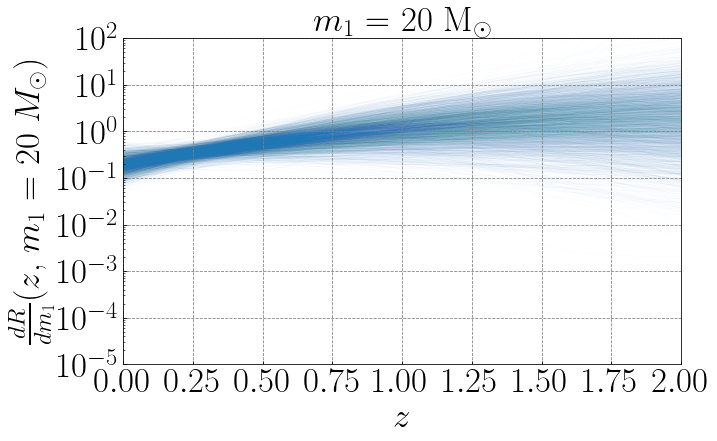

In [5]:
R(20, samps)

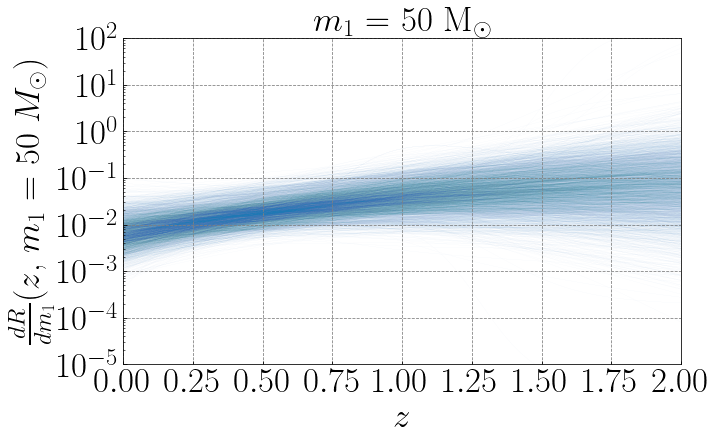

In [6]:
R(50, samps)

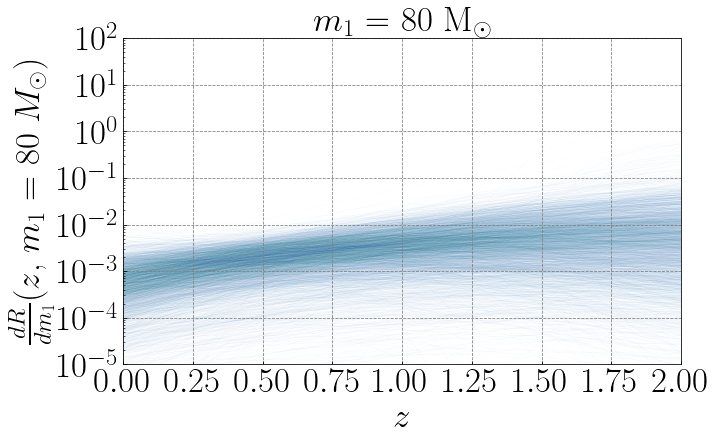

In [7]:
R(80, samps)